# Import modules

In [18]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
import cv2

## MINIST Test (Using FastMINIST)

MixedNational Institute of Standards and Technology Database

In [3]:
# Check if cuda is enable
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
# Download training data and test data
# url = ""
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
# url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz"
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [5]:
# Model definitoin

class NetworkModel(nn.Module):
    def __init__(self):
        super(NetworkModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [6]:
model = NetworkModel().to(device)
print(model)

NetworkModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [7]:
# loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
# dataloaders

batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
for (X, y) in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [9]:
# training function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # predition error
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # save every 100
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [10]:
# test function
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy： {(100 * correct):>0.1f}%, Average loss: {test_loss:>8f} \n")

In [11]:
epochs = 5
for i in range(epochs):
    print(f"---- Epoch {i + 1} ----")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done")

---- Epoch 1 ----
loss: 2.296125 [    0/60000]
loss: 2.294918 [ 6400/60000]
loss: 2.280133 [12800/60000]
loss: 2.282467 [19200/60000]
loss: 2.268439 [25600/60000]
loss: 2.242621 [32000/60000]
loss: 2.261193 [38400/60000]
loss: 2.223575 [44800/60000]
loss: 2.222537 [51200/60000]
loss: 2.223479 [57600/60000]
Test Error: 
 Accuracy： 48.5%, Average loss: 0.034680 

---- Epoch 2 ----
loss: 2.211331 [    0/60000]
loss: 2.215801 [ 6400/60000]
loss: 2.167615 [12800/60000]
loss: 2.190891 [19200/60000]
loss: 2.151850 [25600/60000]
loss: 2.100999 [32000/60000]
loss: 2.159827 [38400/60000]
loss: 2.074177 [44800/60000]
loss: 2.089887 [51200/60000]
loss: 2.097179 [57600/60000]
Test Error: 
 Accuracy： 54.0%, Average loss: 0.032294 

---- Epoch 3 ----
loss: 2.074277 [    0/60000]
loss: 2.069224 [ 6400/60000]
loss: 1.969717 [12800/60000]
loss: 2.029030 [19200/60000]
loss: 1.952966 [25600/60000]
loss: 1.869453 [32000/60000]
loss: 1.991126 [38400/60000]
loss: 1.831150 [44800/60000]
loss: 1.894610 [51200/

In [12]:
# saving model state

torch.save(model.state_dict(), "dist/model.pth")
print("Saved PyTorch Model State to dist/model.pth")

Saved PyTorch Model State to dist/model.pth


In [13]:
# load model state

local_model = NetworkModel()
local_model.load_state_dict(torch.load("dist/model.pth"))

<All keys matched successfully>

In [16]:
# prediction

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]
local_model.eval()

x, y = test_data[1][0], test_data[1][1]
with torch.no_grad():
    pred = local_model(x)
    predict, actual = classes[pred[0].argmax(0)], classes[y]
    print(f"Predict result: {predict}, Actual: {actual}")

Predict result: Pullover, Actual: Pullover


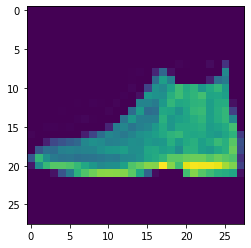

In [35]:
# show dataset image

img = test_data[0][0].numpy()
img = img.reshape(img.shape[1], img.shape[2])
plt.imshow(img)